In this notebook, I am predicting 4th word in relation to word3 based on the relationship between word1 & word2<br>
Input : country1, capital1, country2<br>
Output: capital2

You can find this in Coursera NLP course.  [link](https://www.coursera.org/learn/classification-vector-spaces-in-nlp/home/welcome)

In [147]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
import pickle
import matplotlib.pyplot as plt

In [19]:
# get list of countries and capitals
f = open('capitals.txt','r').read()
country_capital = set(word_tokenize(f))
country_capital

{'Abuja',
 'Accra',
 'Afghanistan',
 'Albania',
 'Algeria',
 'Algiers',
 'Amman',
 'Angola',
 'Ankara',
 'Antananarivo',
 'Apia',
 'Armenia',
 'Ashgabat',
 'Asmara',
 'Astana',
 'Athens',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Baghdad',
 'Bahamas',
 'Bahrain',
 'Baku',
 'Bamako',
 'Bangkok',
 'Bangladesh',
 'Banjul',
 'Beijing',
 'Beirut',
 'Belarus',
 'Belgium',
 'Belgrade',
 'Belize',
 'Belmopan',
 'Berlin',
 'Bern',
 'Bishkek',
 'Botswana',
 'Bratislava',
 'Brussels',
 'Bucharest',
 'Budapest',
 'Bujumbura',
 'Bulgaria',
 'Burundi',
 'Cairo',
 'Canada',
 'Canberra',
 'Caracas',
 'Chile',
 'China',
 'Chisinau',
 'Conakry',
 'Copenhagen',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Dakar',
 'Damascus',
 'Denmark',
 'Dhaka',
 'Doha',
 'Dominica',
 'Dublin',
 'Dushanbe',
 'Ecuador',
 'Egypt',
 'England',
 'Eritrea',
 'Estonia',
 'Fiji',
 'Finland',
 'France',
 'Funafuti',
 'Gabon',
 'Gaborone',
 'Gambia',
 'Georgetown',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Greenland',
 'Guinea',
 'G

### Get Google's word2vec dataset

Find the tutorial to work with word2vec dataset [here](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [ ]:
import gensim.downloader as api
path = api.load('word2vec-google-news-300',return_path=True)

In [21]:
word_vectors = KeyedVectors.load_word2vec_format(path,binary=True)

Now, let's get only the embeddings of words that we need for our task.

In [41]:
#combine country_capital and words_for_pca
words_for_pca = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
all_words = list(country_capital) + words_for_pca
word_embeddings = {}
for word in all_words:
    if word in word_vectors.vocab.keys():
        word_embeddings[word] = word_vectors[word]
    
    

In [44]:
print("length of word_embeddings ",len(word_embeddings))
print("length of all_words ",len(all_words))

length of word_embeddings  243
length of all_words  243


So we have embeddings for all words we wanted. Let's dump this in pickle file so that we can directly load pickle file instead of downloading 1.6GB word2vec.

In [46]:
pickle.dump(word_embeddings,open('word_embeddings_country_capital.p','wb'))

Now, Let's load the embeddings from pickle file which we saved in teh previous line

In [47]:
word_embeddings_word2vec = pickle.load(open('word_embeddings_country_capital.p','rb'))
len(word_embeddings_word2vec)

243

Write a function to find cosine similarity between two word vectors which helpful for finding capitals from countries<br>
$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$

In [48]:
def cosine_similarity(vector1,vector2):
    """
    Find cosine similarity between given vectors
    Input:
    vector1: a numpy array corresponds a word vector
    vector2: a numpy array corresponds a word vector
    Output:
    cos: Cosine similarity between vector1 and vector2
    """
    product = np.dot(vector1,vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    cos = product/(norm1 * norm2)
    return cos

In [68]:
def get_capital(country1,capital1,country2,word_embeddings):
    """
    Get the capital of country2 given country1,capital1,country2 and word_embeddings
    Input:
    country1: a string containing name of country1
    capital1: a string containing name of capital1
    country2: a string containing name of country2
    word_embeddings: a dictionary where keys are words and values are thier embeddings 
    Output:
    capital2: a tuple containing (capital2, cosine_similarity)
    """
    country1_vec = word_embeddings[country1]
    capital1_vec = word_embeddings[capital1]
    country2_vec = word_embeddings[country2]
    inputs = set([country1,capital1,country2])
    
    #the relationship between given inputs can be written as below
    relationship = capital1_vec - country1_vec +  country2_vec 
    
    #initialize cosine similarity to lowest
    similarity = -1
    capital2 = ''
    
    for word in word_embeddings.keys():
        # The capital2 should not be in inputs
        if word not in inputs:
            vec = word_embeddings[word]
            cos = cosine_similarity(vec,relationship)
            if cos > similarity:
                similarity = cos
                capital2 = (word, similarity)
    return capital2
        

In [72]:
print("capital of Uganda ", get_capital('Greece', 'Athens','Uganda', word_embeddings))
print("capital of Italy ", get_capital('Uganda', 'Kampala','Italy', word_embeddings))

capital of Uganda  ('Kampala', 0.6805503)
capital of Italy  ('Rome', 0.6260729)


In [73]:
def test_model(word_embeddings,data):
    """
    Input: 
    word_embeddings: a dictionary where keys are words and values are thier embeddings
    data: a dataframe containing country city pairs (columns: 'city1','country1','city2','country2')
    Output:
    accuracy: the accuracy of the model
    """
    count = 0
    for i,row in data.iterrows():
        capital1 = row['city1']
        country1 = row['country1']
        capital2 = row['city2']
        country2 = row['country2']
        predicted_capital,_ = get_capital(country1,capital1,country2,word_embeddings)
        if predicted_capital == capital2:
            count += 1
    accuracy = (count/(len(data)))*100
    return accuracy  

In [76]:
# get the test data
data = pd.read_csv('../input/capitals.txt',delimiter=' ',)
data.columns = ['city1', 'country1', 'city2', 'country2']

In [78]:
print("accuracy ",test_model(word_embeddings,data))

accuracy  86.93193294283984


In [136]:
#Compute PCA
def compute_pca(X,n_components=2):
    #subtract mean from x
    X = X-np.mean(X,axis=0)
    #covariance matrix
    cov_matrix = np.cov(X,rowvar=False) #rowvarbool, optional
                            #If rowvar is True (default), then each row represents a variable, with observations in the columns. Otherwise, the relationship is transposed: each column represents a variable, while the rows contain observations.
    #get eigen values and vectors of covariance matrix
    eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix,UPLO='L')
    #print("eigen values ",eigen_values,eigen_values.shape)
    # sort eigen values in decreasing order of explained variance
    idx_sorted = np.argsort(eigen_values,axis=0)
    idx_decreasing = idx_sorted[::-1]
    eigen_values_sorted = eigen_values[idx_decreasing]
    #print("eigen values ",eigen_values_sorted,eigen_values_sorted.shape)
    eigen_vectors_sorted = eigen_vectors[:,idx_decreasing]
    components = eigen_vectors_sorted[:,0:n_components]
    #print("shapes of eigen vectors {} \n shape of X {}".format(components.shape,X.shape))
    X_uncorrelated = np.dot(components.transpose(),X.transpose()).transpose()
    return X_uncorrelated

In [144]:
word_embedding_pca = []
words_for_pca = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']
for word in words_for_pca:
    word_embedding_pca.append(word_embeddings[word])
X = np.array(word_embedding_pca)
X_uncorrelated = compute_pca(X)

In [145]:
X_uncorrelated.shape

(11, 2)

Now plot the reduced dimensions((13,300) -->(13, 2)) to see the relations between words

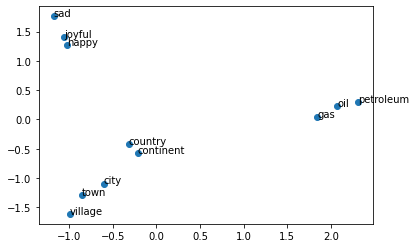

In [146]:

plt.scatter(X_uncorrelated[:,0],X_uncorrelated[:,1])
for i,word in enumerate(words_for_pca):
    plt.annotate(word,(X_uncorrelated[i,0],X_uncorrelated[i,1]))

Eventhough PCA reduced 300 variables to 2 variables, it retains the importtant info in the original dataset which we can observe in the graph where related words like (joyful, happy, sad)-->emotions and (city,town,village), (gas,oil,petrolium) they are seen close to each other. Since we can't visualize 300 dimesions, PCA is very helpful to visualize if our model is doing well